In [1]:
%load_ext autoreload
%autoreload 2
%cd /mnt/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *
from src.active_learning.tta_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

import pandas as pd
import numpy as np
import itertools
import os

import json
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


sns.set(font_scale=1.4)
sns.set(rc={'figure.figsize':(12,6)})

/mnt/activeCell-ACDC
README.md					log
ac_acdc_env					nohup.out
acdc_large_cls_test_slim_coco_format.json	notebooks
acdc_large_cls_test_slim_coco_format.json.lock	output
al_output					pipeline_configs
coco_instances_results.json			requirements.txt
data						shell_scripts
experiments					src
instances_predictions.pth			utils
jupyter_notebooks				wandb


/mnt/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "experiments/results/uncertainty/results_10_0.35_3000.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
max_id = df[df["agg_uncertainty"] == df["agg_uncertainty"].max()]["image_id"].values[0]
min_id = df[df["agg_uncertainty"] == df["agg_uncertainty"].min()]["image_id"].values[0]
df.sort_values("agg_uncertainty").tail(10)["image_id"].values

array(['acdc_data3_20211029_pos_4_54', 'acdc_data2_F016_pos_3_93',
       'acdc_data3_20211029_pos_4_45', 'acdc_data3_20210722_pos_18_3',
       'acdc_data3_20211029_pos_4_48', 'acdc_data3_20211029_pos_1_96',
       'acdc_data2_F016_pos_3_18', 'acdc_data3_20211029_pos_4_33',
       'acdc_data3_20211029_pos_4_42', 'acdc_data2_F016_pos_3_15'],
      dtype=object)

In [5]:
min_id

'acdc_data2_F016_pos_3_0'

In [6]:
df["agg_uncertainty"].min()

0.014221311

In [7]:
def val2dicts(val):

    preds = []
    for v in val:
        pred_masks = v["pred_masks"].detach().cpu().numpy()
        pred_classes = v["pred_classes"].detach().cpu().numpy()

        preds.append({
            "pred_masks": pred_masks,
            "pred_classes": pred_classes,
        })

    return preds

def get_uncertainties(im_json, model, query_strategy):

    im = query_strategy.load_image(im_json)
    instance_list = query_strategy.get_samples(model, im, cfg.AL.NUM_MC_SAMPLES)
    combinded_instances = query_strategy.get_combinded_instances(instance_list)


    height, width = im.shape[:2]
    agg_uncertainty = query_strategy.get_uncertainty(combinded_instances, cfg.AL.NUM_MC_SAMPLES, height, width, mode=cfg.AL.OBJECT_TO_IMG_AGG)

    
    uncertainties = []

    for key, val in combinded_instances.items():

        val_len = torch.tensor(len(val)).to("cuda")

        if query_strategy.cfg.MODEL.ROI_HEADS.NUM_CLASSES > 1:
            u_sem = query_strategy.get_semantic_certainty(val, device = "cuda").detach().cpu().numpy()
        else:
            u_sem = 0
        u_mask = query_strategy.get_mask_certainty(val, height, width, val_len, device="cuda").detach().cpu().numpy()
        u_box = query_strategy.get_box_certainty(val, val_len, device="cuda").detach().cpu().numpy()
        u_det = query_strategy.get_detection_certainty(cfg.AL.NUM_MC_SAMPLES, val_len, device="cuda").detach().cpu().numpy()
        
        

        cpu_val = val2dicts(val)

        uncertainties.append({
            "val": cpu_val,
            "u_sem": u_sem,
            "u_mask": u_mask,
            "u_box": u_box,
            "u_det": u_det,

        })


    
    return uncertainties, agg_uncertainty

In [8]:
dataset = ACDC_LARGE_CLS
config_name = "classes_acdc_large_al"
#config_name = "final_random_al"

model_path = "/mnt/activeCell-ACDC/al_output/classes_acdc_large_al/random"




In [9]:
register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get("acdc_large_cls_test_slim")

registering acdc_large dataset
registering acdc_large_cls dataset


In [10]:
wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [11]:
default_cfg = get_config(config_name)
cfg = default_cfg
#cfg.AL.OBJECT_TO_IMG_AGG = "mean"
cfg.OUTPUT_DIR = "./al_output/final_random_al"
cfg.AL.NUM_MC_SAMPLES = 10
dropout_prob = 0.35
cfg.MODEL.ROI_HEADS.DROPOUT_PROBABILITY = dropout_prob
cfg.MODEL.ROI_MASK_HEAD.DROPOUT_PROBABILITY = dropout_prob
cfg.MODEL.ROI_BOX_HEAD.DROPOUT_PROBABILITY = dropout_prob
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05

In [50]:
mc_strategy = MCDropoutSampler(cfg)

model = load_model(cfg, os.path.join(model_path, "best_model5800.pth"))
mc_model = patch_module(model)



rd.seed(1338)
sample_data = rd.sample(train_data, 10)

In [13]:
def show_uncertainties(im_json, model, query_strategy):
    
    uncertainties, agg_uncertainty = get_uncertainties(im_json, model, query_strategy)
    print(im_json["image_id"], agg_uncertainty)
    total_pred_mask = np.max(np.stack([np.mean(np.stack([val["pred_masks"] for val in uncertainty["val"]]), axis=0) for uncertainty in uncertainties]), axis = 0)
    class_pred_mask = np.max(np.stack([np.max(np.stack([val["pred_masks"] > 0 for val in uncertainty["val"]]), axis=0)*uncertainty["u_sem"] for uncertainty in uncertainties]), axis = 0)
    det_pred_mask = np.max(np.stack([np.max(np.stack([val["pred_masks"] > 0 for val in uncertainty["val"]]), axis=0)*uncertainty["u_det"] for uncertainty in uncertainties]), axis = 0)
    im = load_image(im_json)
    show_image([im,total_pred_mask, class_pred_mask, det_pred_mask],colormap="plasma")
    return
    for uncertainty in uncertainties:

        if uncertainty["u_det"] < 1 or uncertainty["u_mask"] < 0.9 or uncertainty["u_sem"] < 0.6:
            print("number of detections", len(uncertainty["val"]), "u_sem", uncertainty["u_sem"], "u_mask", uncertainty["u_mask"], "u_box", uncertainty["u_box"], "u_det", uncertainty["u_det"])
            if query_strategy.cfg.MODEL.ROI_HEADS.NUM_CLASSES > 1:
                print(pd.Series([val["pred_classes"] for val in uncertainty["val"]]).value_counts())
            mask = np.mean(np.stack([val["pred_masks"] for val in uncertainty["val"]]), axis=0)
            print(np.sum(mask > 0))
            show_image([mask, total_pred_mask + mask], normalize=False, colormap="plasma")

In [14]:
max_json = [image_json for image_json in test_data if image_json["image_id"] == "acdc_data3_20211029_pos_1_96"][0]
min_json = [image_json for image_json in test_data if image_json["image_id"] == min_id][0]


ids = list(df.sort_values("agg_uncertainty").tail(5)["image_id"].values) + list(df.sort_values("agg_uncertainty").head(5)["image_id"].values)
print(ids)
image_jsons = [image_json for image_json in test_data if image_json["image_id"] in ids]



['acdc_data3_20211029_pos_1_96', 'acdc_data2_F016_pos_3_18', 'acdc_data3_20211029_pos_4_33', 'acdc_data3_20211029_pos_4_42', 'acdc_data2_F016_pos_3_15', 'acdc_data2_F016_pos_3_0', 'acdc_data2_kurt_306-3_0_20201028_pos_1_12', 'acdc_data2_kurt_306-3_0_20201028_pos_1_9', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_87', 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_21']


/mnt/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_21 0.018903136


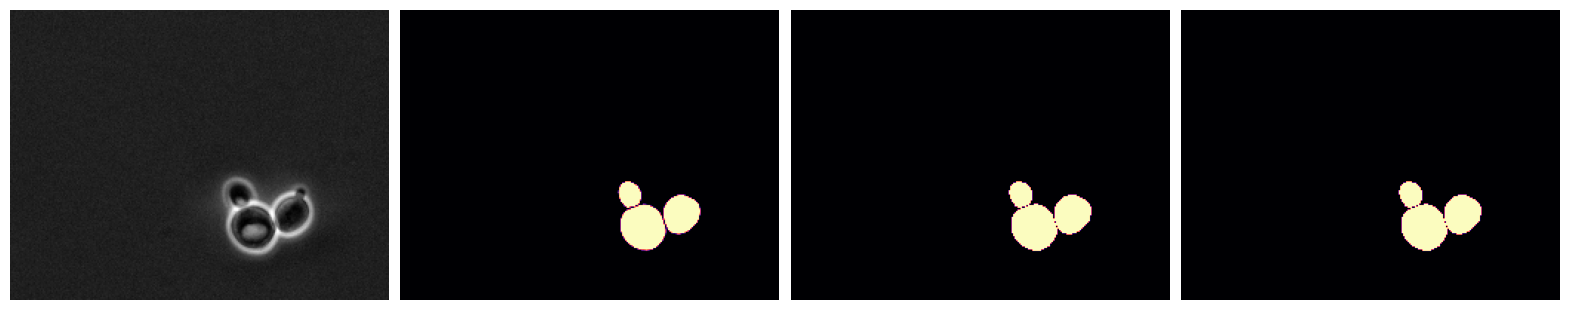

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_87 0.032141056


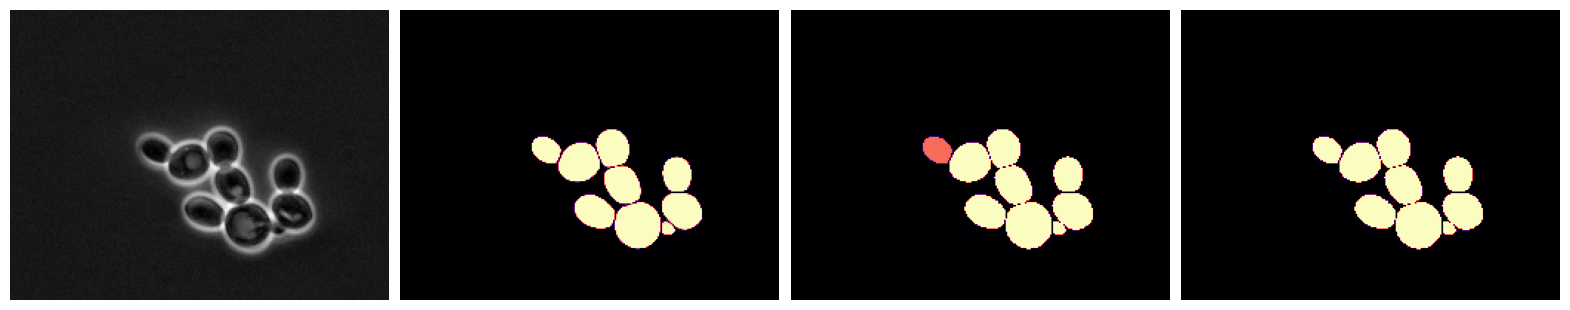

acdc_data2_F016_pos_3_0 0.011884004


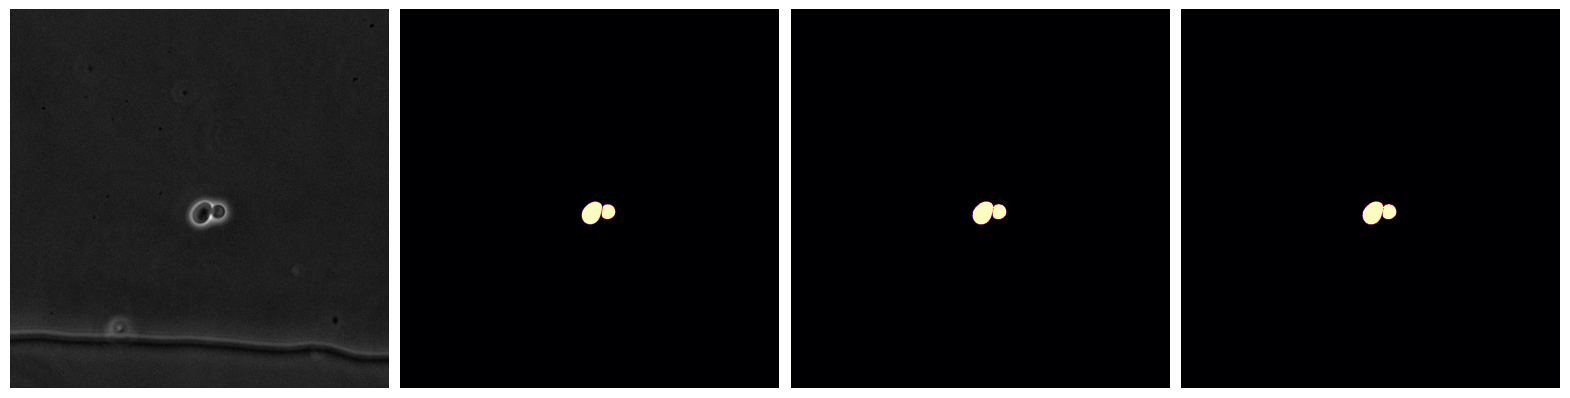

acdc_data2_F016_pos_3_15 0.47113672


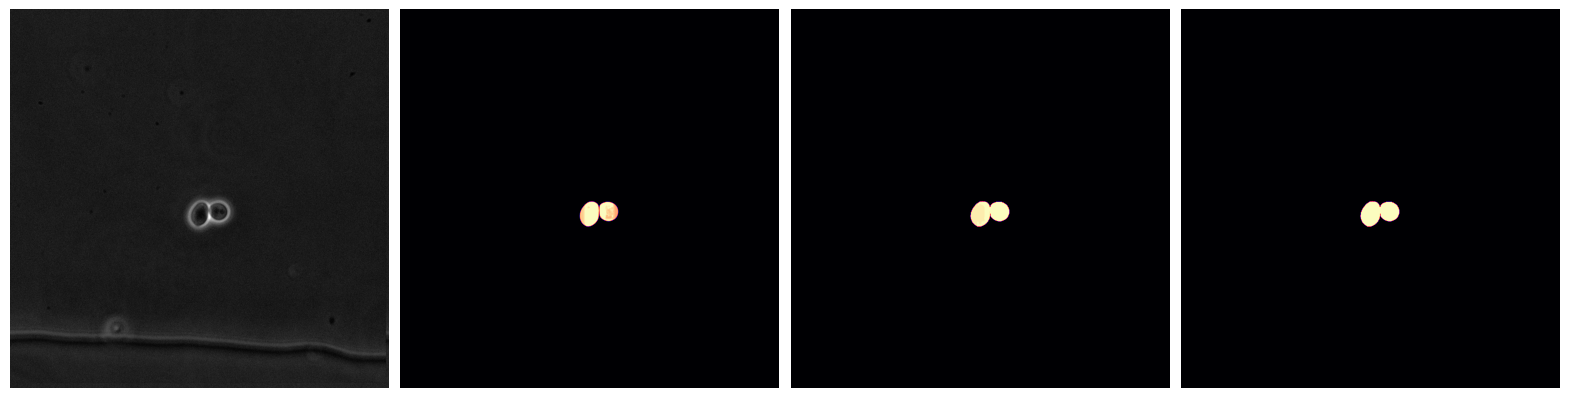

acdc_data2_F016_pos_3_18 0.38919595


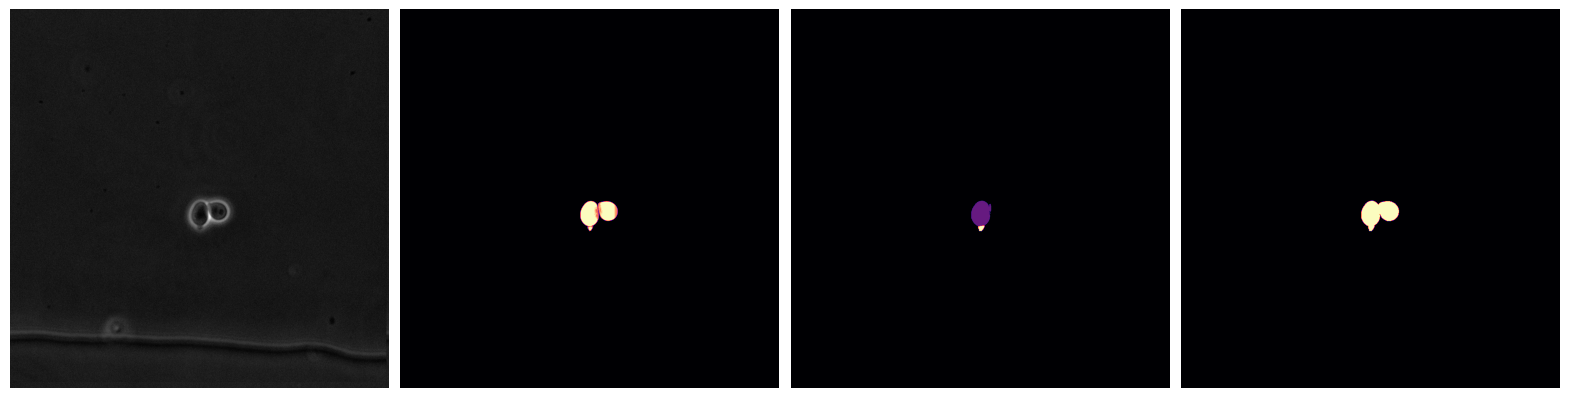

acdc_data2_kurt_306-3_0_20201028_pos_1_12 0.03167227


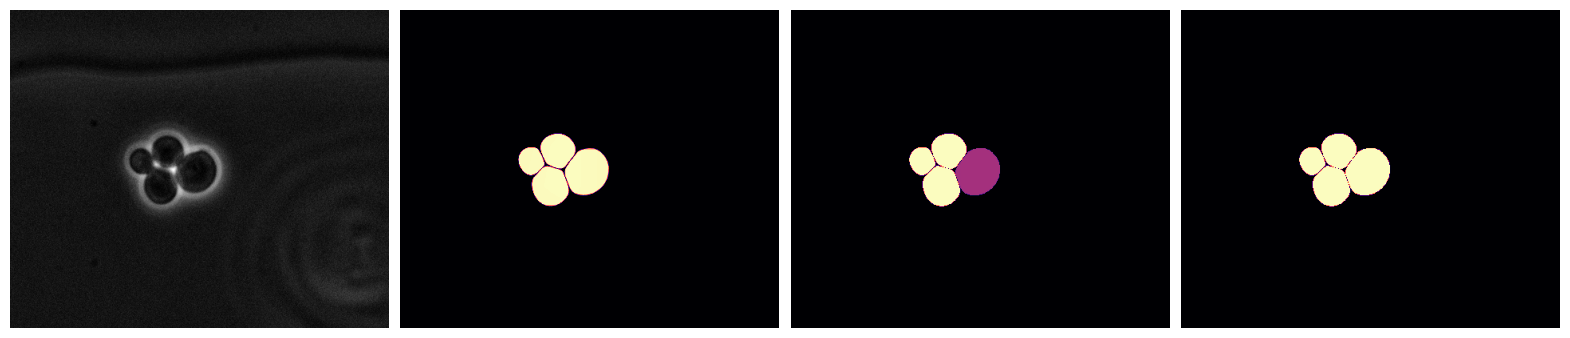

acdc_data2_kurt_306-3_0_20201028_pos_1_9 0.013836697


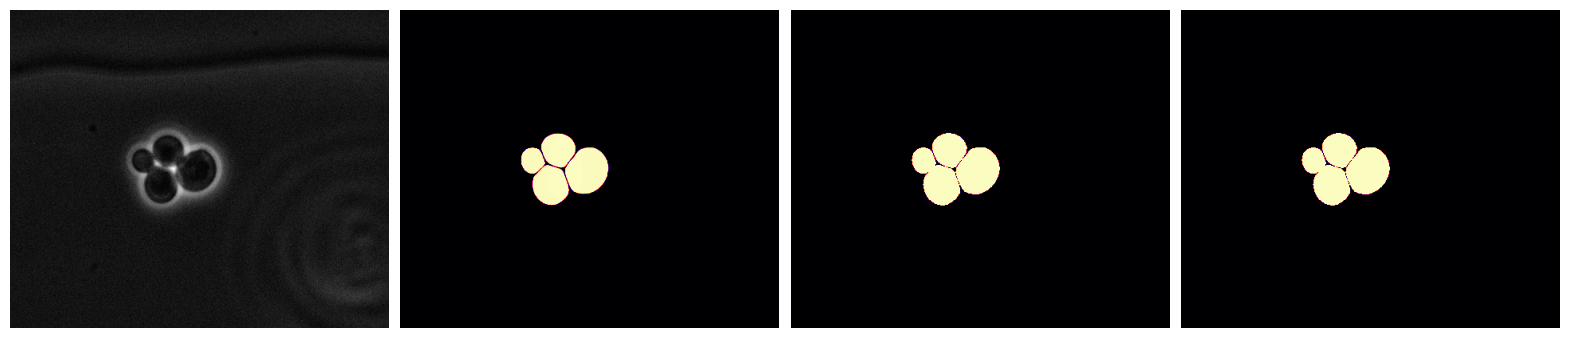

acdc_data3_20211029_pos_1_96 0.2757693


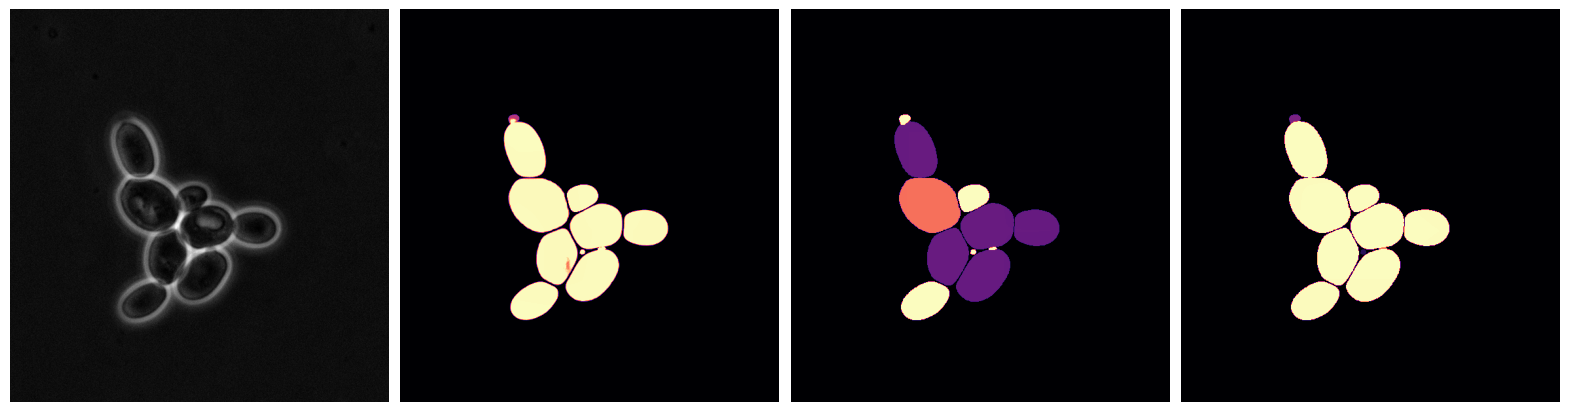

acdc_data3_20211029_pos_4_33 0.40602368


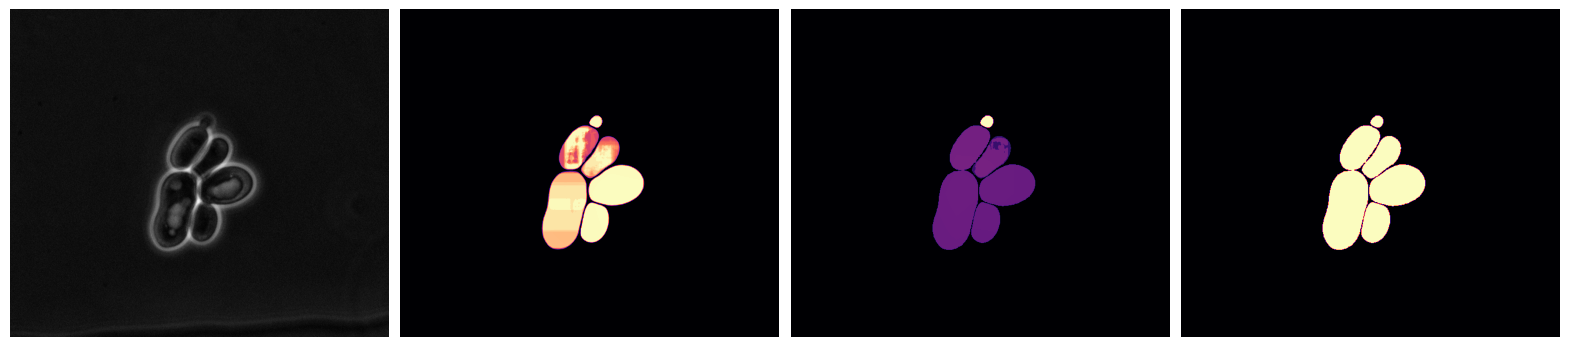

acdc_data3_20211029_pos_4_42 0.41875234


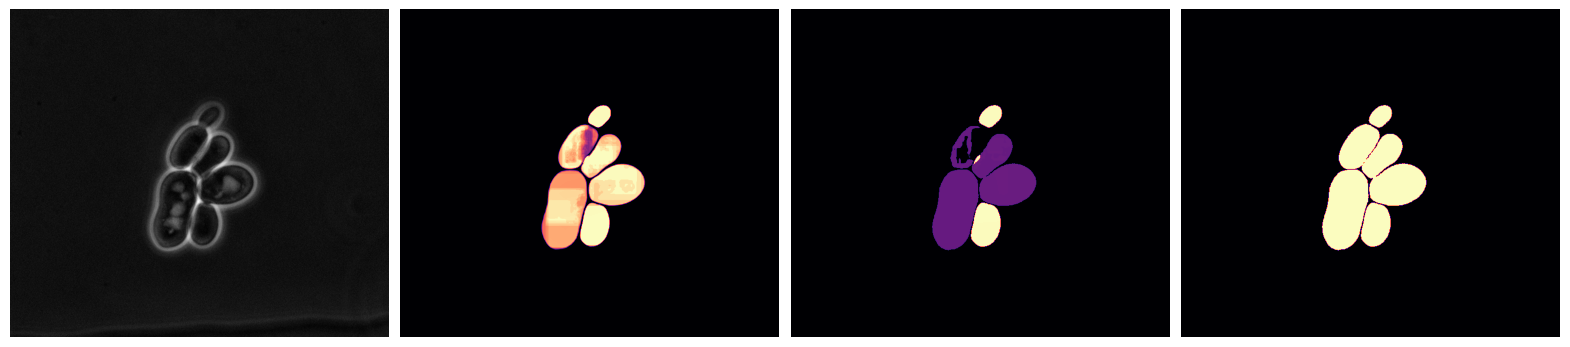

In [15]:

for image_json in image_jsons:
    show_uncertainties(image_json, mc_model, mc_strategy)

100%|█████████████████████████████████████████████████████████████████| 509/509 [00:18<00:00, 28.23it/s]
/tmp/ipykernel_848267/4079835062.py:148: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.scatterplot(


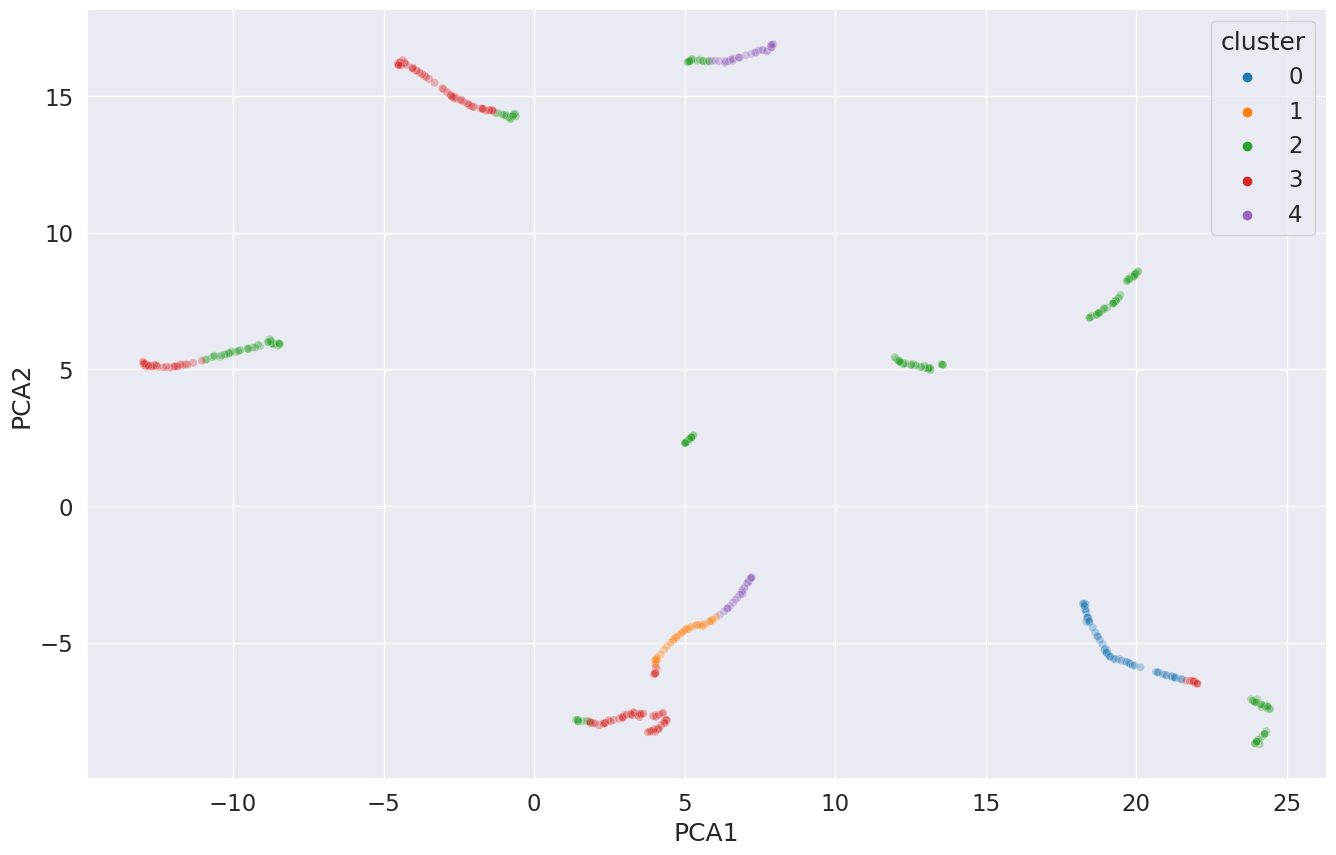

In [51]:
import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os, sys
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import umap

sys.path.append("/home/florian/GitRepos/activeCell-ACDC")


from src.globals import *
from utils.visualization.show_image import show_image
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

#register_datasets()
#ds_json = DatasetCatalog.get(get_dataset_name(
#    ACDC_LARGE, DATASETS_DSPLITS[ACDC_LARGE][0]
#))


#cfg = get_config("acdc_large_al")
#cfg.OUTPUT_DIR = "./output/default_acdc_large_full_ds"
#cfg.AL.OBJECT_TO_IMG_AGG = "mean"


###########################################
do_inference = True
offs = 5 #10 # size of used feature map center +- offs
skip_images = 10 # only use every skip_images th image in video

###########################################


rand_int = 4
id_pool =  [id["image_id"] for id in test_data]#list(filter(lambda x: (int(x.split("_")[-1]) + rand_int) % skip_images == 0, [id["image_id"] for id in ds_json])) # [id["image_id"] for id in ds_json]

#model = mc_model
model.eval()

#checkpointer = DetectionCheckpointer(model)
#checkpointer.load(os.path.join(cfg.OUTPUT_DIR, "best_model.pth"))



if do_inference:
    feature_vector =  []
    for id in tqdm(id_pool):
        im_json = list(filter(lambda x: x["image_id"] == id, test_data))[0]
        input_image = cv2.imread(im_json["file_name"])

        aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        height, width = input_image.shape[:2]
        image = aug.get_transform(input_image).apply_image(input_image)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": height, "width": width}]

        images = model.preprocess_image(inputs)
        features = model.backbone(images.tensor)

        x_1, x_2 = features["p5"].shape[2], features["p5"].shape[3]

        
        feature_vector.append(features["p5"].to("cpu").detach().numpy()[:,:,int(x_1/2)-offs:int(x_1/2)+offs,int(x_2/2)-offs:int(x_2/2)+offs].flatten())



    mat = np.stack(feature_vector)
    np.savez_compressed("experiments/results/latent_space.npz", mat)
    
else:
    
    mat = np.load("experiments/results/latent_space.npz")["arr_0"]
    
##### UMAP  
umap_embedding = umap.UMAP(random_state=42).fit_transform(mat)

##### PCA  
pca = PCA()
pca_embedding = pca.fit_transform(X=mat)


df = pd.DataFrame({
    "id":id_pool,
    "pca_dim_0":pca_embedding[:, 0],
    "pca_dim_1":pca_embedding[:,1],
    "pca_dim_2":pca_embedding[:,2],
    "umap_dim_0":umap_embedding[:, 0],
    "umap_dim_1":umap_embedding[:, 1],
})

X = np.array(umap_embedding)

kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(mat)
df["cluster"] = kmeans.labels_

video_ids = {}
i = 0
for video in set(["_".join(name.split("_")[:-1]) + "_" for name in df["id"].values]):
    video_ids[video] = i
    i += 1
    
df["video_id"] = df.apply(lambda row: int(video_ids["_".join(row["id"].split("_")[:-1]) + "_"]),axis=1)
df["image_id"] = df["id"].str.split("_").str[-1].astype("int")
df["pos_video"] = df["image_id"] < 120
df["Classes"] = "Class 1"
df.loc[df["image_id"] > 120, "Classes"] = "Class 2"
num_cells = {im_json["image_id"]:len(im_json["annotations"]) for im_json in test_data}
df["num_cells"] = df.apply(lambda row: float(num_cells[row["id"]]),axis=1)
df["experiment"] = df["id"].str.split("_pos").str[0]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap_dim_0", y="umap_dim_1",
    hue="cluster",
    palette=sns.color_palette("tab10"), # ("ch:s=.25,rot=-.25", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
sns.set(font_scale=1.5)
plt.show()


In [52]:
df_new = pd.merge(df,pd.read_csv(path), left_on="id", right_on="image_id")

/tmp/ipykernel_848267/2874962092.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


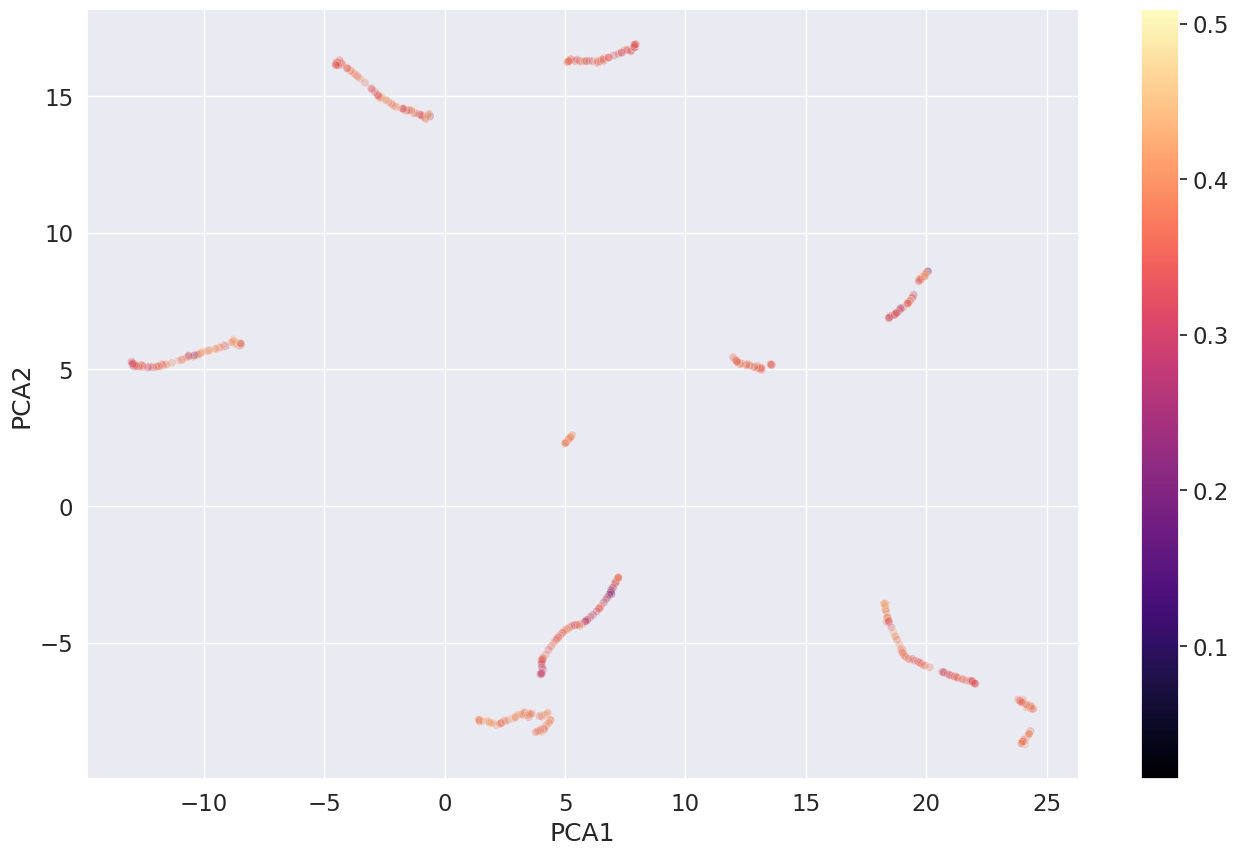

In [53]:
plt.figure(figsize=(16,10))


ax = sns.scatterplot(
    x="umap_dim_0", y="umap_dim_1",
    hue="agg_uncertainty",
    palette=sns.color_palette("flare", as_cmap=True),
    data=df_new,
    legend="full",
    alpha=0.3
)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
sns.set(font_scale=1.5)

norm = plt.Normalize(df_new['agg_uncertainty'].min(), df_new['agg_uncertainty'].max())
sm = plt.cm.ScalarMappable(cmap=sns.color_palette("magma", as_cmap=True), norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)




plt.show()

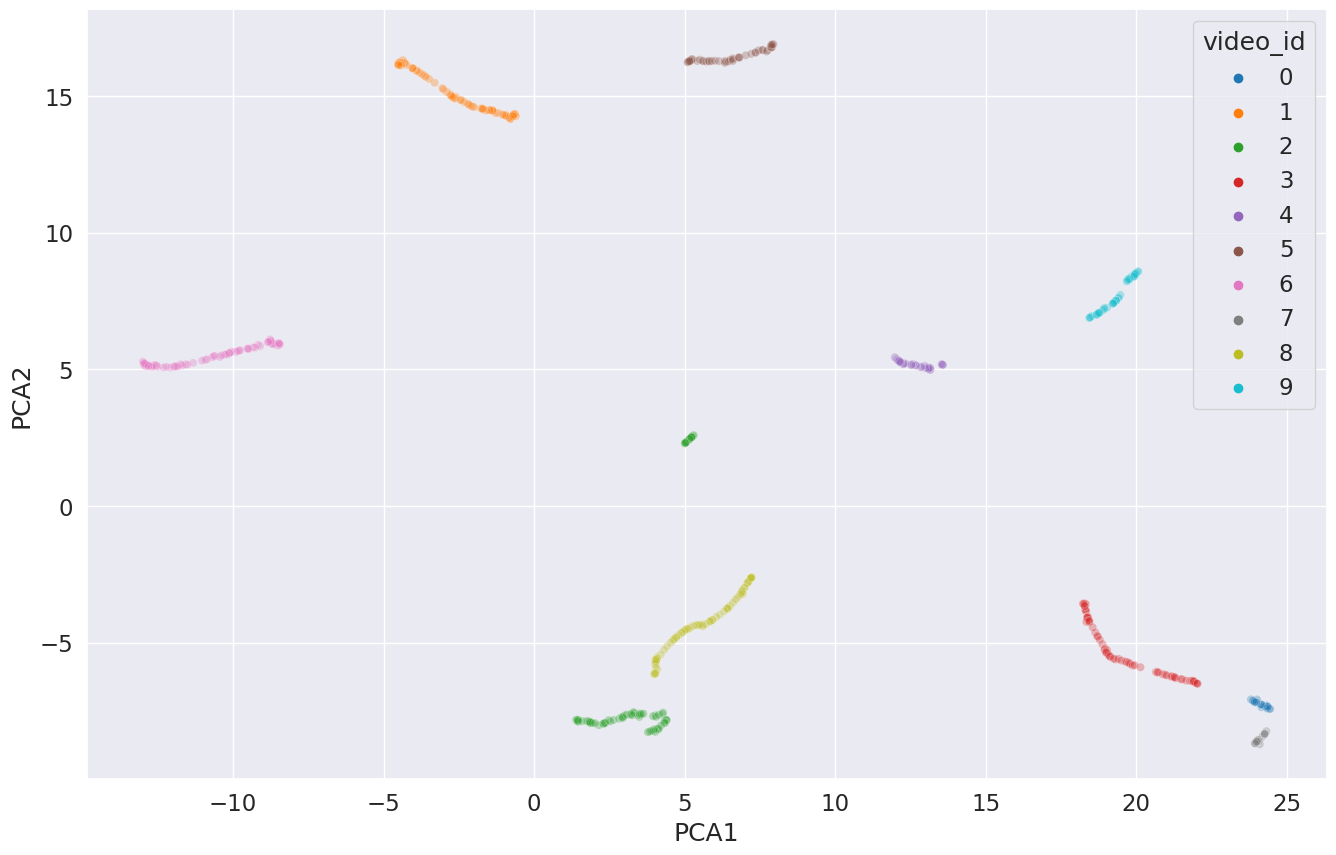

In [55]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap_dim_0", y="umap_dim_1",
    hue="video_id",
    palette=sns.color_palette("tab10"), # ("ch:s=.25,rot=-.25", as_cmap=True),
    data=df,
    legend="full",
    alpha=0.3
)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
sns.set(font_scale=1.5)
plt.show()